In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
# Without this line matlib will crash 
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [20]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [21]:
len(words)

32033

In [22]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i , c in enumerate(chars)}
stoi ['.'] = 0
itos = {i: c for c , i in stoi.items()}
vocab_size = len(itos)
print (itos)
print (vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [23]:
# build the dataset for training, validation and test
block_size = 3 # trigram model

def build_dataset(words):
    block_size = 3 
    X, Y = [], []
    for w in words: 
        context = [0] * block_size # context window [0, 0, 0]
        for ch in w + '.': 
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # add new char in the end and removes the first one

    X = torch.tensor(X) # X has trigram contexts
    Y = torch.tensor(Y) # Y has index of each character that the trigram corresponds to. For example for first letter e, trigram is [0, 0, 0] and Y[0] = 5; for second letter e, trigram is [0, 0, 5] and Y[1] = 5;
    print (X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
 
Xtr, Ytr = build_dataset(words[:n1]) # 80% of the words for training
Xdev, Ydev = build_dataset(words[n1:n2]) # 10% 
Xts, Yts = build_dataset(words[n2:]) # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [113]:
# MLP revisited
n_embd = 10 # embedding size
n_hidden = 200 # hidden layer size

g = torch.Generator().manual_seed(2147483627)  
C = torch.randn(vocab_size, n_embd, generator=g)  # 27 x 10
#W1 = torch.randn(n_embd * block_size, n_hidden , generator=g) * 0.2 # 30 x 200
W1 = torch.randn(n_embd * block_size, n_hidden , generator=g) * (5/3)/((n_embd * block_size)**0.5) # 30 x 200 # kaiming initialization 0.3
# b1 = torch.randn(n_hidden, generator=g) * 0.01 # 200 x 1
# bnbias will take care of the bias. b1 does not do anything. Its grad will be zero... 
W2 = torch.randn(n_hidden, vocab_size, generator=g) * 0.01 # 200 x 27
b2 = torch.randn(vocab_size, generator=g) * 0 # 27 x 1

bngain = torch.ones(1, n_hidden)  # 1 x 200
bnbias = torch.zeros(1, n_hidden) # 1 x 200
bnmean_running = torch.zeros(1, n_hidden) # 1 x 200 
bnstd_running = torch.ones(1, n_hidden) # 1 x 200
# mean = 0 and std = 1 for the first batch, that is what we initialize in the W1 and b1. 
# we are not going to in gradient descent. We just calculating in parallel. 

paramaters = [C, W1, b1, W2, b2, bngain, bnbias] # Need to include bngain and bnbias in the list of paramaters, since it will be used in the backpropagation
print ( sum(p.nelement() for p in paramaters) )
for p in paramaters:
    p.requires_grad = True

12297


In [ ]:
# Fixing the initial loss.. 
# 0/ 200000 loss: 32.5641 this is more than -log(1/27) = 3.2958, if it where a normal distribution. So the initial loss is not correct. Why? logits (log counts) take on extreme values. 
#logits[0]
#tensor([-23.2061,  -3.8688,  -0.4207,   1.7597,  -4.6089,   7.2212,  -6.2135,
      #     3.6278,   2.4491, -10.6197, -14.1598,  28.7946,  14.2200,   2.7358,
      #   -12.3023, -22.9448,   4.5978,   1.7225,  11.7055, -16.3703,  30.5306,
      #     5.0593,  -3.7374,  14.3168,  13.8984,   5.0136,  21.6552],
      #  grad_fn=<SelectBackward0>)

# We need to find a way to me the logits come more closer to zero
# 1. Make b2 = 0 we dont want add bias because want to make the logits closer to zero
# 2. Make W2 smaller. We will multibility by 0.1 to make it smaller
# 3. Let run the first iteration and see what happens
# 4. We brought down to 0/ 200000 loss: 4.5024 that is better. But it is still more than -log(1/27) = 3.2958
# 5. Let make W2 smaller by multibility by 0.01
# 6. We brought down to 0/ 200000 loss: 3.3323 that is better. But it is still more than -log(1/27) = 3.2958
# 7. Why not make W2 = 0. That is dangerous. We dont want to make W2 = 0 because we want to learn something.So keep some values. And it adds some entropy to the model that is important for symmetry breaking.
# 8. logits[0] are coming close to zero
# tensor([-0.2174, -0.0545,  0.0014,  0.0135, -0.0422,  0.0823, -0.0525,  0.0261,
#          0.0311, -0.1094, -0.1511,  0.2916,  0.1453,  0.0112, -0.1249, -0.2126,
#          0.0440,  0.0200,  0.1122, -0.1608,  0.3154,  0.0591, -0.0397,  0.1331,
#          0.1389,  0.0470,  0.2089], grad_fn=<SelectBackward0>)
# 9. Now let us run the optimization for 200000 iterations
# 10. We brought down the loss to 190000/ 200000 loss: 1.8573. 
# 11. train loss: 2.0644 , val loss: 2.1291
# 12. What we did in all the above steps: is to make the hockey stick to go away, and make the model more productive from get go. 

In [ ]:
# Fixing tanh
# Even though we fixed initial loss, there other problems lurking in the model.
# 1. logits are okay now. 
# 2. Problem is with the hidden layer. h. 
# tensor([[ 1.0000,  0.9999, -0.0819,  ...,  0.9990,  0.9996, -1.0000],
#         [-0.8221,  1.0000, -0.9955,  ...,  0.1631, -0.3367,  0.9880],
#         [-0.8867, -0.7361, -1.0000,  ...,  0.9024,  1.0000,  0.8829],
#         ...,
#         [-0.9930,  0.7010,  0.9981,  ..., -0.9998,  0.6440, -0.6685],
#         [ 0.9999,  0.8276,  0.9998,  ..., -0.9989,  1.0000, -0.9991],
#         [ 0.7049,  1.0000, -0.9994,  ...,  1.0000,  0.9994, -0.9886]],
#        grad_fn=<TanhBackward0>)
# Many of them are 1 or -1 are close to it. That is not good. 
# 3. to visualize it, we will plot the histogram of the hidden layer.
# plt.hist(h.view(-1).tolist(), 50) and plt.hist(hpreact.view(-1).tolist(), 50). You will see most of the values that comes out of tanh  are close to 1 or -1. and preact hae wide distribution. 
# # If you look at backward fn in micrograd def _backward():
#             self.grad += (1 - t**2) * out.grad
# you will see that the gradient is 1 - t**2. So if t is close to 1 or -1, the gradient is close to 0. So the gradient is not flowing back to the input. It cuts off the gradient.
# 4. So we need to make sure that there are no dead neurons. We did that. there is no white column in the histogram.
# 5. We compared various activation functions. tanh, ReLU, sigmoid, leaky ReLU. 
# 6. So what should we do? to make sure that backpropagation works well. We need to bring the values of hpreact closer to zero.
# 7. We will do that by multibility W1 by 0.1 and b by 0.0 to keep entropy.
# 8. Run the optimization for 1 iteration. Look at the histogram. It is h has better distribution close normal distribution.
# 9. hpreact has values are lose to zero.
# 10. Figure shows all neurons are active. Shows full back. backpropagation is working well.
# 11. It was all black. So we changed W1 from 0.1 to 0.2 that allowed some neurons to take extreme values.
# 12. We will run the optimization for 200000 iterations
# 13. train loss: 2.0353 , val loss: 2.1040 this is better than before.
# train loss: 2.0644 , val loss: 2.1291. We are doing productive training... 


In [ ]:
# Since the model is single layer... it is forgiving, if it is deep than activation, gradient vanishing, exploding, etc. are big problems.

In [77]:
(5/3) / (30**0.5)

0.3042903097250923

In [76]:
# See the trick 
(torch.randn(10000) * 0.2 ).std() # 1.0 If we multiply by 0.2, the std will be 0.2. That is why we multiplied by 0.2 in the above code.

tensor(0.1998)

In [ ]:
# If we train with kaiming initialization, 
# we got: 
# train loss: 2.0374, val loss: 2.1080
# previous run's: train loss: 2.0353 , val loss: 2.1040

In [ ]:
# Batch Normalization
# Insight: What we did in the above step is to normalize the input to the hidden layer W1*emb + b and normalize the hidden layer output (tanh). Now insight is: why dont we normalize the preact directly instead of doing it before and after the activation function.Hidden preactivation is perfectly differentiable operation. 
# 1. We will add normalization to the hidden layer preactivation by
# hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) # 32 x 200 # batch normalization
# This will normalize the 32 randomly selected mini batch.
# Mean and variance are perfectly diffrentiable operations. So we can backpropagate through them.
# But we dont want normalize each iteration. We want the backpropagation to move around and tell us the best fit. 
# They way we do that as in the paper is: we scale and shift. 
# 2. We will add two parameters to the model: gamma (gain) and beta (bias). we multiply the gain with the normalized value and add the bias to oscilate. 
# 3. Output we got are: 
# train loss: 2.0374, val loss: 2.1080
# All the metrics are looking good. 
# What this model achieves is the it will get jitters for h and logits.. This has the effect of regularizing the model. This has the effect of data augmentation. This make it hard for the neural network to overfit. This give a stable effect.
# 4. Since batch is tightly coupled with the model, how will you get forward pass and get output for single example. 
# 5. Calibrate the batch norm at the end of the training.
# 6. Output we got are:
# train loss: 2.0665, val loss: 2.1093

In [94]:
hpreact.mean(0, keepdim=True),  # 32 X 200 -> 1 X 200

(tensor([[ 0.6578,  1.2550, -0.7806, -0.5917,  1.1198, -0.6178,  0.1274, -0.1517,
          -0.2204, -0.1968,  0.3684,  0.0682, -0.1346,  0.2862, -0.7879,  1.1064,
           0.9895,  0.3939,  0.1106,  1.2633, -0.3504,  0.4641,  0.3359,  0.0757,
          -0.6579,  0.1954, -0.5213, -0.4316,  0.0313,  0.2505,  0.8879, -0.9476,
           0.5737,  0.1918,  1.3271, -0.0361, -1.4326, -0.0875,  0.2428,  0.5508,
           0.2689, -0.2356,  0.9191, -1.8406,  0.5418, -1.1816,  0.7952, -1.0003,
           0.3177,  1.5513, -0.1640,  0.1339, -0.2800,  0.6653,  0.2684,  0.5176,
          -0.5770,  0.3680,  0.9758,  0.0044,  0.4807, -0.4285,  1.6421, -0.4228,
          -0.0635,  0.8150, -0.3426,  0.0509,  0.7196, -0.9023,  1.8548,  1.0240,
           0.2913,  0.9031, -0.1785,  0.2907,  0.3964,  0.7722,  0.2699,  0.1861,
          -0.1639,  0.0644,  0.1476,  0.1433, -0.6651,  0.4395, -0.3034,  0.3414,
          -1.7872,  1.9395, -0.9825,  0.2033, -0.9127,  0.4457, -1.0434, -0.2690,
          -0.581

In [97]:
hpreact.std(0, keepdim=True)

tensor([[2.3275, 2.4576, 2.2898, 1.6678, 2.4038, 1.7706, 3.2021, 1.7339, 2.3481,
         2.7089, 2.2896, 1.9002, 2.1385, 2.6063, 2.2721, 2.8138, 2.3216, 2.1901,
         1.9966, 1.8066, 1.8553, 1.6158, 2.5994, 1.4786, 2.6910, 2.3970, 2.3360,
         2.7009, 1.6970, 2.2795, 2.0691, 2.1796, 3.2932, 1.8225, 3.1972, 2.2520,
         2.4886, 1.4223, 1.8708, 1.9766, 2.1890, 1.5974, 1.8876, 3.0098, 2.1904,
         3.0982, 2.2616, 2.2919, 1.8908, 2.4179, 1.7065, 2.5431, 1.8178, 2.8117,
         1.5599, 1.5987, 2.0085, 2.5687, 1.7702, 1.6156, 2.0537, 1.4734, 2.1418,
         1.5956, 1.9237, 1.5963, 2.3075, 1.9264, 1.9918, 2.4590, 2.4193, 1.8277,
         2.3608, 2.4533, 2.1622, 1.1588, 1.6999, 2.5571, 1.7863, 1.6960, 1.8415,
         2.0533, 1.2571, 1.9124, 1.9476, 1.5174, 1.8462, 1.5140, 1.9614, 2.3661,
         1.6689, 1.7167, 2.0141, 2.3124, 2.0050, 1.7216, 1.8104, 2.3214, 2.4396,
         1.5792, 1.4212, 2.4304, 2.1770, 1.8031, 0.9853, 2.1827, 1.4576, 1.3158,
         2.4573, 2.2986, 1.7

tensor(0.0127) tensor(0.9909)
tensor(-0.0020) tensor(0.9743)


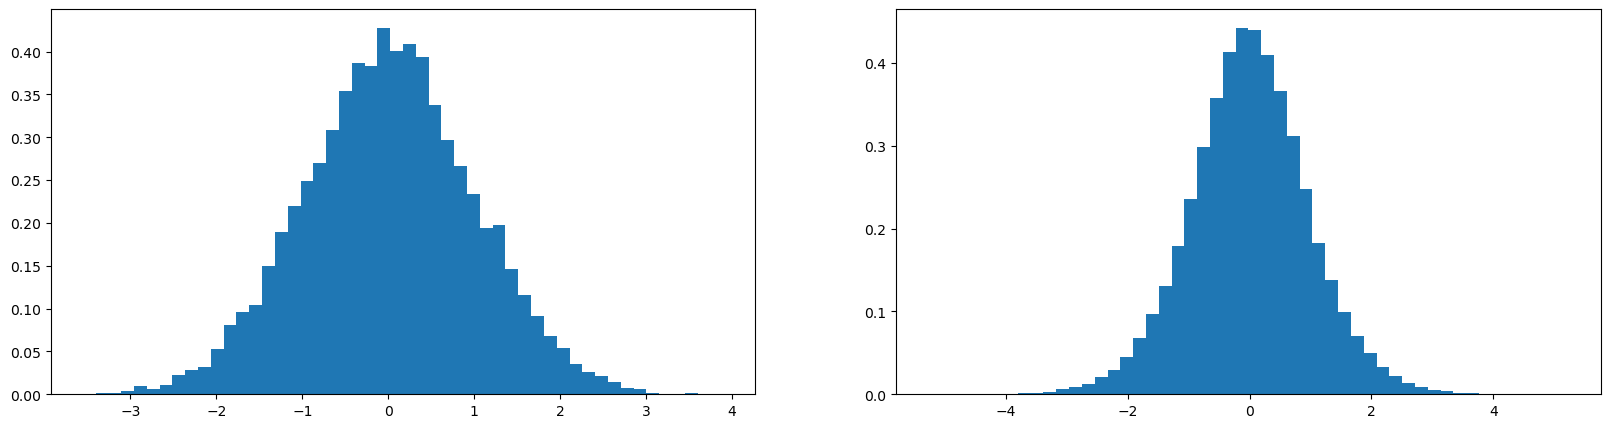

In [114]:
# Calculating the initial scale. How we know what initial values that should be multiplied to W1 and b to make the model work well instead of guessing and checking.
# 1. 
x = torch.randn(1000, 10) # Gaussian with mean 0 and variance 1
w = torch.randn(10, 200) / 10**0.5
# The answer is to divide W by the square root of the number of feature inputs. fein = 10. So we divide by 10.
# * 0.2 # 5 is expanding... 0.2 is squashing to variance of 1
y = x @ w 
# what will be distribution of y? As the plot below shows it is non-gaussian.tensor(-0.0043) tensor(3.2534). We are expanding the distribution. How to make it remain gaussian? We need to scale the distribution.
print(x.mean(), x.std()) #tensor(-0.0166) tensor(1.0053)
print(y.mean(), y.std()) #tensor(-0.0043) tensor(3.2534)
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), 50, density=True) ; # semicolon to suppress output
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), 50, density=True) ; # semicolon to suppress output

In [115]:
# same optimization as last time 
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps): 

  # minibatch construct 
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # 32 random indices
  Xb, Yb = Xtr[ix], Ytr[ix] # 32 x 3, 32 x 1

  # forward pass
  emb = C[Xb] # 32 x 3 x 10
  embcat = emb.view(emb.shape[0], -1) # 32 x 30
  # Linear Layer
  hpreact = embcat @ W1 # + b1 # 32 x 30 @ 30 x 200 + 200 = 32 x 200 # hidden layer pre-activation
  # BatchNorm Layer
  #---------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True) # 32 x 200 -> 1 x 200
  bnstdi = hpreact.std(0, keepdim=True) # 32 x 200 -> 1 x 200
  hpreact = bngain * (hpreact - bnmeani) / bnstdi  + bnbias # 32 x 200 # batch normalization
  with torch.no_grad(): # not tracking gradients
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # 1 x 200
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi # 1 x 200
  #---------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # 32 x 200 # hidden layer activation
  logits = h @ W2 + b2 # 32 x 200 @ 200 x 27 + 27 = 32 x 27 # output layer 
  loss = F.cross_entropy(logits, Yb)  # 32 x 27, 32 x 1

  # backward pass
  for p in paramaters:
    p.grad = None # setting the gradients to zero
  loss.backward() # backward pass

  # updating learning rate
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in paramaters:
    p.data += -lr * p.grad # nudge each node / parameters 

  # track stats
  if i % 10000 == 0:
    print ( f'{i:7d}/{max_steps:7d} loss: {loss.item():.4f}' )
  lossi.append(loss.log10().item()) 



      0/ 200000 loss: 3.3239
  10000/ 200000 loss: 2.4986
  20000/ 200000 loss: 2.5710
  30000/ 200000 loss: 2.5897
  40000/ 200000 loss: 2.2763
  50000/ 200000 loss: 2.3182
  60000/ 200000 loss: 2.2710
  70000/ 200000 loss: 2.7623
  80000/ 200000 loss: 1.7537
  90000/ 200000 loss: 2.1749
 100000/ 200000 loss: 2.4135
 110000/ 200000 loss: 2.2611
 120000/ 200000 loss: 2.0947
 130000/ 200000 loss: 2.1285
 140000/ 200000 loss: 2.1235
 150000/ 200000 loss: 2.0129
 160000/ 200000 loss: 1.7325
 170000/ 200000 loss: 2.0214
 180000/ 200000 loss: 1.7195
 190000/ 200000 loss: 1.9823


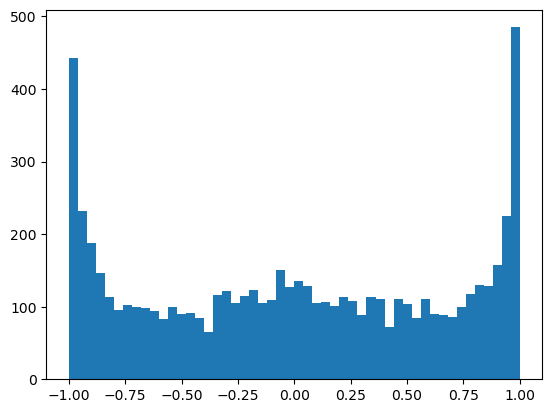

In [106]:
plt.hist(h.view(-1).tolist(), 50) ; # 50 bins and ; to supress the output

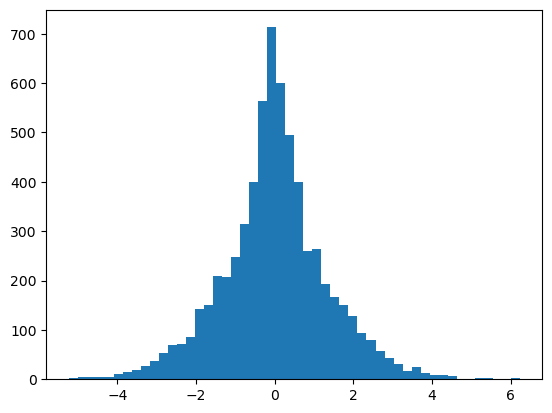

In [107]:
plt.hist(hpreact.view(-1).tolist(), 50) ;

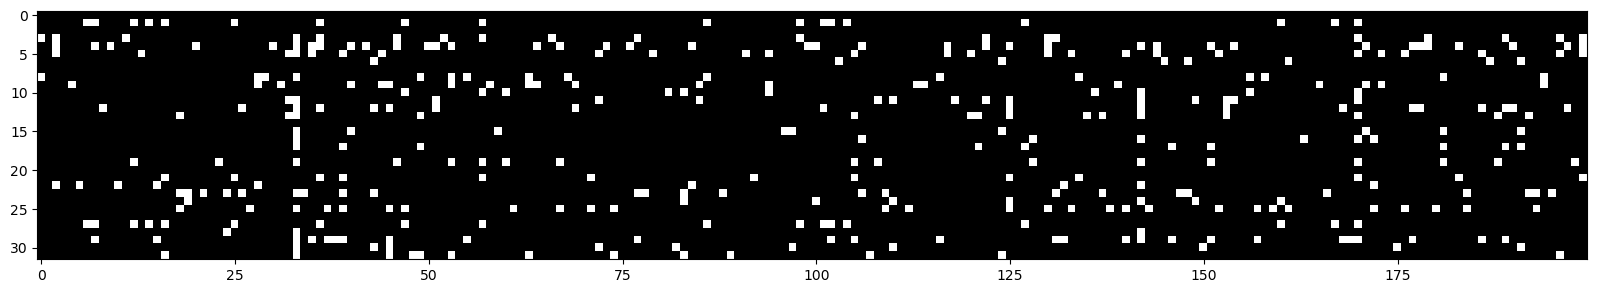

In [108]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');
# If h.abs() > 0.99 then it is white. If there was complete white then that would be wrong. 

In [63]:
logits[0]

tensor([ 2.6428,  3.5701, -2.5882,  0.8725, -0.3080,  2.6605, -3.6702, -4.1634,
         3.9418,  2.6481, -2.0946, -1.6816,  1.3168, -1.6043, -0.0102,  2.2300,
        -3.4651, -4.4198,  1.3965,  0.4444,  1.2122,  0.1932, -0.4532, -3.1948,
        -1.2996,  4.2140,  2.1809], grad_fn=<SelectBackward0>)

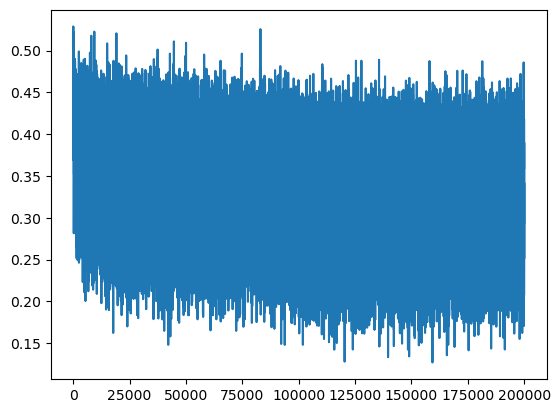

In [109]:
plt.plot(lossi)

In [111]:
# calibrate the batch norm at the end of the training
# since we are doing bnmean_running and bnstd_running, we dont need the explicit calibration... 

with torch.no_grad():
    # pass the training set through the model with no backword pass
    emb = C[Xtr] # 32 x 3 x 10
    embcat = emb.view(emb.shape[0], -1) # 32 x 30
    hpreact = embcat @ W1 + b1 # 32 x 30 @ 30 x 200 + 200 = 32 x 200 # hidden layer pre-activation
    # measure the mean and variance over the entire training set
    bnmean = hpreact.mean(0, keepdim=True) # 1 x 200
    bnstd = hpreact.std(0, keepdim=True) # 1 x 200

In [118]:
bnstd

tensor([[2.3954, 1.7591, 2.4409, 2.0786, 2.5226, 2.3885, 2.2250, 2.3996, 2.1487,
         2.3668, 2.2341, 2.3794, 2.3740, 2.3120, 2.3238, 2.6184, 2.1566, 1.7728,
         2.3209, 2.6049, 1.9632, 2.1671, 2.0774, 2.0277, 2.0599, 2.4546, 2.3012,
         2.1393, 2.6752, 1.9399, 2.0201, 2.1259, 1.9869, 2.3566, 2.1253, 2.1465,
         2.2969, 2.1062, 2.0264, 2.1887, 2.2487, 2.0724, 1.9421, 2.2076, 2.2522,
         3.0590, 2.0301, 2.1053, 1.9957, 2.2084, 2.3312, 2.3002, 1.9940, 2.2819,
         1.9690, 1.9442, 1.6057, 2.7329, 1.9743, 2.2834, 2.0159, 2.1158, 1.6481,
         2.5594, 1.9070, 1.8710, 2.0912, 1.8639, 2.1448, 2.4067, 2.0721, 2.1114,
         2.2375, 2.5388, 2.2284, 1.7803, 2.3429, 2.2447, 2.4949, 2.1560, 2.0135,
         1.7913, 2.1783, 2.4057, 2.1663, 2.0190, 2.0525, 2.0403, 1.9797, 1.9193,
         1.7895, 2.4365, 2.3165, 2.1333, 1.9285, 1.8661, 2.0243, 2.3249, 2.3411,
         2.2652, 2.2350, 2.5183, 2.3992, 2.0409, 2.1061, 2.3863, 2.2444, 2.3456,
         1.9303, 2.3468, 2.3

In [119]:
bnstd_running

tensor([[2.3747, 1.7416, 2.4145, 2.0594, 2.5063, 2.3676, 2.2050, 2.3954, 2.1307,
         2.3522, 2.2096, 2.3552, 2.3515, 2.2934, 2.3048, 2.6109, 2.1292, 1.7582,
         2.3016, 2.5866, 1.9509, 2.1460, 2.0547, 1.9808, 2.0316, 2.4383, 2.2805,
         2.1182, 2.6467, 1.9224, 2.0127, 2.1100, 1.9614, 2.3433, 2.1026, 2.1182,
         2.2806, 2.0814, 1.9966, 2.1809, 2.2221, 2.0608, 1.9239, 2.1902, 2.2378,
         3.0359, 2.0089, 2.0779, 1.9726, 2.1854, 2.3223, 2.2792, 1.9790, 2.2496,
         1.9520, 1.9273, 1.5821, 2.7146, 1.9551, 2.2582, 1.9975, 2.0975, 1.6346,
         2.5256, 1.8789, 1.8558, 2.0746, 1.8498, 2.1162, 2.3838, 2.0538, 2.0763,
         2.2143, 2.5288, 2.1950, 1.7655, 2.3381, 2.2201, 2.4662, 2.1341, 1.9931,
         1.7785, 2.1568, 2.3824, 2.1470, 2.0088, 2.0307, 2.0290, 1.9591, 1.8944,
         1.7637, 2.4028, 2.2940, 2.1167, 1.9150, 1.8394, 1.9988, 2.3080, 2.3233,
         2.2416, 2.2023, 2.4898, 2.3758, 2.0168, 2.0920, 2.3608, 2.2242, 2.3199,
         1.9084, 2.3274, 2.3

In [112]:
@torch.no_grad() # no need to track gradients
def split_loss (split): 
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xts, Yts),
    }[split]
    emb = C[x] # (N, block_size, n_embd) 
    embcat = emb.view(emb.shape[0], -1) # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)
    #hpreact = bngain * ((hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True))  + bnbias # 32 x 200 # batch normalization
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias # (N, n_hidden

    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y) # (N, vocab_size), (N,)
    print (f'{split} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')


train loss: 2.0665
val loss: 2.1093


In [16]:
context = [0] * block_size # initialize will all '...' chars
torch.tensor(context)
emb = C[torch.tensor([context])] 
emb

tensor([[[-1.0440, -1.1457, -0.4851,  0.4165,  0.0111,  0.3233, -0.7345,
          -0.4008,  0.0065,  1.0427],
         [-1.0440, -1.1457, -0.4851,  0.4165,  0.0111,  0.3233, -0.7345,
          -0.4008,  0.0065,  1.0427],
         [-1.0440, -1.1457, -0.4851,  0.4165,  0.0111,  0.3233, -0.7345,
          -0.4008,  0.0065,  1.0427]]], grad_fn=<IndexBackward0>)

In [17]:
# how to sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize will all '...' chars
    while True:
        emb = C[torch.tensor([context])] # (1, block_size=3, n_embd) 
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) # (1, block_size, n_embd) @ (n_embd*blocksize * n_hidden + (n_hidden, 1) = (1, 200)
        logits = h @ W2 + b2 # (1, 200) @ (200, 27) + (27,) = (1, 27)
        probs = F.softmax(logits, dim=1) # (1, 27)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() # (1, 1)
        context = context[1:] + [ix] # (3, ) + (1, ) = (3, )
        out.append(ix)
        if ix == 0:
            break
    
    print("".join(itos[i] for i in out))


carmah.
ambril.
khyim.
shree.
casplani.
ejrah.
bradherric.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
join.
quintin.
lilea.
jadiquinte.
madiarisi.
jace.
pinsleigh.
edi.


In [18]:
-torch.tensor(1/100).log()

tensor(4.6052)